In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Ref
* [Encoder-Decoder in Tensorflow](https://www.angioi.com/time-series-encoder-decoder-tensorflow/)

# Importing data and building dataset

In [3]:
df = pd.read_csv('bike_data/hour.csv', index_col='instant')

In [4]:
df.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
def select_columns(df):
    cols_to_keep = [       
      'cnt',
      'temp',
      'hum',
      'windspeed',
      'yr',
      'mnth', 
      'hr', 
      'holiday', 
      'weekday', 
      'workingday']
    df_subset = df[cols_to_keep]
    return df_subset

def onehot_encode_integers(df, excluded_cols):
    df = df.copy()

    int_cols = [col for col in df.select_dtypes(include=['int']) if col not in excluded_cols]

    df.loc[:, int_cols] = df.loc[:, int_cols].astype('str')

    df_encoded = pd.get_dummies(df)
    return df_encoded

def normalize_cnt(df):
    df = df.copy()
    df['cnt'] = df['cnt'] / df['cnt'].max()
    return df

In [6]:
dataset = (df.pipe(select_columns).pipe(onehot_encode_integers, excluded_cols=['cnt']).pipe(normalize_cnt))

In [7]:
dataset

,cnt,temp,hum,windspeed,yr,mnth,hr,holiday,weekday,workingday
instant,,,,,,,,,,
1,0.016377,0.24,0.81,0.0000,0,1,0,0,6,0
2,0.040942,0.22,0.80,0.0000,0,1,1,0,6,0
3,0.032753,0.22,0.80,0.0000,0,1,2,0,6,0
4,0.013306,0.24,0.75,0.0000,0,1,3,0,6,0
5,0.001024,0.24,0.75,0.0000,0,1,4,0,6,0
...,...,...,...,...,...,...,...,...,...,...
17375,0.121801,0.26,0.60,0.1642,1,12,19,0,1,1
17376,0.091095,0.26,0.60,0.1642,1,12,20,0,1,1
17377,0.092119,0.26,0.60,0.1642,1,12,21,0,1,1


In [8]:
def create_dataset(df, n_deterministic_features,context_window, forecast_window, batch_size):
    shuffle_buffer_size = len(df)
    # context_window + forecast_window
    total_size = context_window + forecast_window

    data = tf.data.Dataset.from_tensor_slices(df.values)

    # selecting windows
    data = data.window(total_size, shift=1, drop_remainder=True)
    data = data.flat_map(lambda k: k.batch(total_size))

    # shuffling data
    data = data.shuffle(shuffle_buffer_size, seed=42)

    # extracting past features + deterministic future + labels
    data = data.map(lambda k: ((k[:-forecast_window], k[-forecast_window:, -n_deterministic_features:]), k[-forecast_window:,0]))
  
    return data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

## Encoder Decoder Data
<img src="encoder_decoder.png" width="300" height="150">

In [9]:
dataset

,cnt,temp,hum,windspeed,yr,mnth,hr,holiday,weekday,workingday
instant,,,,,,,,,,
1,0.016377,0.24,0.81,0.0000,0,1,0,0,6,0
2,0.040942,0.22,0.80,0.0000,0,1,1,0,6,0
3,0.032753,0.22,0.80,0.0000,0,1,2,0,6,0
4,0.013306,0.24,0.75,0.0000,0,1,3,0,6,0
5,0.001024,0.24,0.75,0.0000,0,1,4,0,6,0
...,...,...,...,...,...,...,...,...,...,...
17375,0.121801,0.26,0.60,0.1642,1,12,19,0,1,1
17376,0.091095,0.26,0.60,0.1642,1,12,20,0,1,1
17377,0.092119,0.26,0.60,0.1642,1,12,21,0,1,1


In [10]:
# times at which to split train/validation and validation/test
val_time = 10000
test_time = 14000

context_length = 24 * 7 * 3 # three weeks
# How far ahead do we want to generate forecasts?
forecast_length = 24 * 5 # five days

# auxiliary constants
n_total_features = len(dataset.columns)
exclude_colums = ['cnt','temp','hum','windspeed']
n_exclude_features = len(exclude_colums)
n_deterministic_features = n_total_features - n_exclude_features

# splitting dataset into train/val/test
training_data = dataset.iloc[:val_time]
validation_data = dataset.iloc[val_time:test_time]
test_data = dataset.iloc[test_time:]


# Now we get training, validation, and test as tf.data.Dataset objects

batch_size = 32

training_windowed = create_dataset(training_data, 
                                   n_deterministic_features,
                                   context_length,
                                   forecast_length,
                                   batch_size)

validation_windowed = create_dataset(validation_data, 
                                     n_deterministic_features,
                                     context_length,
                                     forecast_length,
                                     batch_size)

test_windowed = create_dataset(test_data, 
                               n_deterministic_features,
                               context_length,
                               forecast_length,
                               batch_size=1)

# Model building/training (point predictions)

In [9]:
latent_dim = 16

# First branch of the net is an lstm which finds an embedding for the past
past_inputs = tf.keras.Input(shape=(context_length, n_total_features), name='past_inputs')
# Encoding the past
encoder = tf.keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(past_inputs)

future_inputs = tf.keras.Input(shape=(forecast_length,n_deterministic_features), name='future_inputs')
# Combining future inputs with recurrent branch output
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True)
x = decoder_lstm(future_inputs, initial_state=[state_h, state_c])

x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='relu')(x)

model = tf.keras.models.Model(inputs=[past_inputs, future_inputs], outputs=output)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.Huber()
model.compile(loss=loss, optimizer=optimizer, metrics=["mae"])

history = model.fit(training_windowed, epochs=25, validation_data=validation_windowed)

Epoch 1/25
294/294 [==============================] - 39s 109ms/step - loss: 0.0066 - mae: 0.0795 - val_loss: 0.0077 - val_mae: 0.0977
Epoch 2/25
294/294 [==============================] - 36s 105ms/step - loss: 0.0013 - mae: 0.0342 - val_loss: 0.0069 - val_mae: 0.0923
Epoch 3/25
294/294 [==============================] - 36s 106ms/step - loss: 0.0012 - mae: 0.0324 - val_loss: 0.0068 - val_mae: 0.0910
Epoch 4/25
294/294 [==============================] - 35s 104ms/step - loss: 0.0012 - mae: 0.0309 - val_loss: 0.0079 - val_mae: 0.1016
Epoch 5/25
294/294 [==============================] - 35s 102ms/step - loss: 0.0011 - mae: 0.0303 - val_loss: 0.0067 - val_mae: 0.0906
Epoch 6/25
294/294 [==============================] - 35s 103ms/step - loss: 0.0011 - mae: 0.0296 - val_loss: 0.0071 - val_mae: 0.0957
Epoch 7/25
294/294 [==============================] - 35s 103ms/step - loss: 0.0011 - mae: 0.0297 - val_loss: 0.0062 - val_mae: 0.0851
Epoch 8/25
294/294 [==============================] - 3

In [10]:
model.evaluate(test_windowed)

2756/2756 [==============================] - 41s 14ms/step - loss: 0.0067 - mae: 0.0782


[0.006739998236298561, 0.07818024605512619]

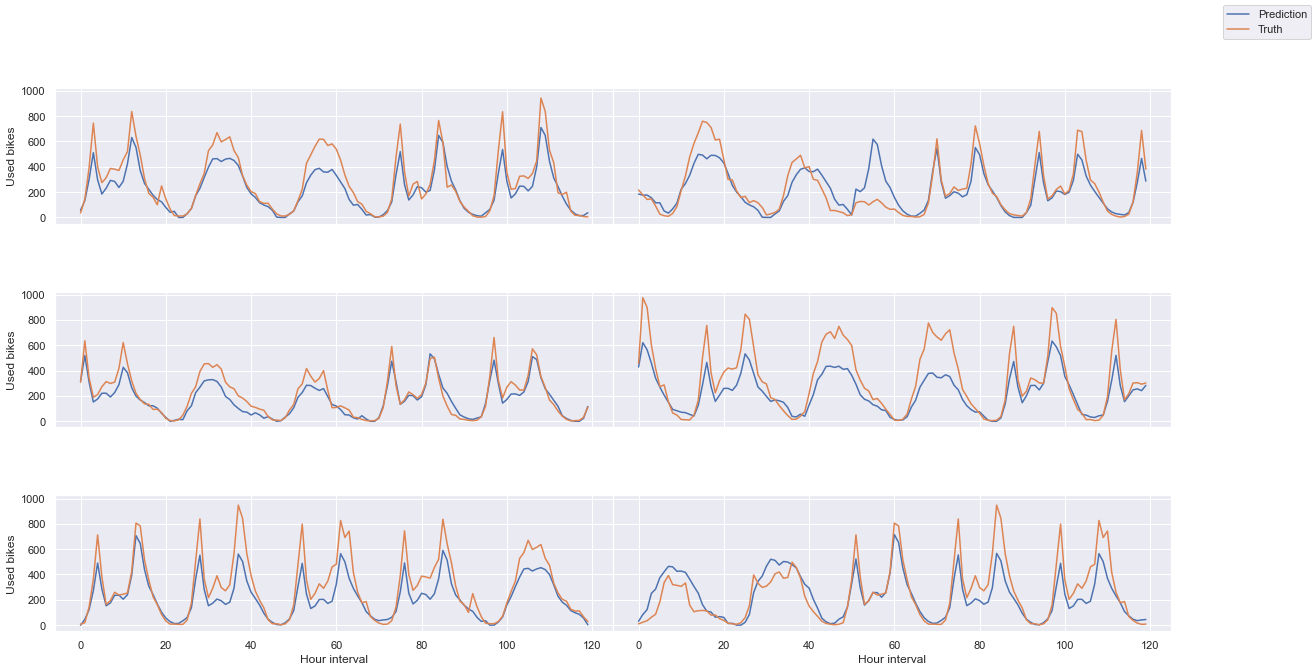

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex='all', sharey='all', figsize=(20, 10))

# We need to rescale cnt
scaling_factor = df.cnt.max()

for i, data in enumerate(test_windowed.take(6)):
    (past, future), truth = data

    truth = truth * scaling_factor
    pred = model.predict((past, future)) * scaling_factor

    row = i//2
    col = i%2

    ax[row][col].plot(pred.flatten(), label='Prediction')
    ax[row][col].plot(truth.numpy().flatten(),label='Truth')

# Labeling axes
for i in range(2):
    ax[2][i].set_xlabel('Hour interval')
for i in range(3):
    ax[i][0].set_ylabel('Used bikes')

handles, labels = ax[0][0].get_legend_handles_labels()
fig.subplots_adjust(wspace=0, hspace=0.5)
fig.legend(handles, labels, loc='upper right')

# Gluonts

* [Gluonts](https://ts.gluon.ai/)